# polyA Single Nucleotide Repeats (SNRs) in mm10
## Data Setup

In [6]:
import SNRdetection as det
import SNRanalysis as ana
import RNAseqAnalysis as seq

import os
import time
import seaborn
import numpy as np
import pandas as pd
import scipy.stats as sps

import matplotlib.colors as mcols
import ipywidgets as widgets
from IPython.display import display
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

pio.templates.default = 'plotly_white'

t_all = time.time()

# Input parameters
base = 'A'
minFeatLen = 1
minSNRlen = 5
cpus = 50
cpuFractionRange = (400, 50)
bamFiltFeat = 'exon'
wind = 2000
log10Filter = 2
lastBP = 250
covThreshold = 0.05
minLen = 0
endLenMin = 50
endLenMax = 500
product = False
stat = 'Product' if product else "Youden's J statistic"

# Parameters specific to this set of inputs
ref = 'refdata-cellranger-mm10-3.0.0'
species = 'Mus musculus'
paper = 'Harrison2019'

# Folder paths
data_folder = '/dartfs-hpc/rc/home/h/f002b9h/BoscoG/polyA/sequencing_data/'
scratch = '/dartfs-hpc/rc/home/h/f002b9h/my-scratch'

ref_input = data_folder + 'refs/input/' + ref + '/'
ref_output = data_folder + 'refs/output/' + ref + '/'
data_output = data_folder + paper + '/output/SRR7695649/polyaf/'


# INPUT FILES
fasta = ref_input + 'fasta/genome.fa' if os.path.isfile(ref_input + 'fasta/genome.fa') \
    else ref_input + 'fasta/genome.fna'
gff = ref_input + 'genes/genes.gtf' if os.path.isfile(ref_input + 'genes/genes.gtf') \
    else ref_input + 'genes/genes.gff'
# Input created by STAR alignment from fastq files
bamfile = data_folder + paper + '/output/SRR7695649/alignment/Aligned.sortedByCoord.out.bam'

# OUTPUT FILES
# Saved with names reflecting the specific parameters
#  so that they are run again when the input parameters change:

# REFERENCE ONLY
# Database of the gff file (up to 5 hours)
out_db = ref_output + 'gffdb.db'
# These 4 files result from scanning the genome for polyAs (~66 hr)
#  New '-1' version accounts for 1-based open intervals of the region() function
#  New '-cd' version also includes discordant features
out_snrs = ref_output + 'snrs_{}-{}-{}.pkl'.format(base, minFeatLen, minSNRlen)
out_csv = ref_output + 'snrCounts_{}-{}-{}.csv'.format(base, minFeatLen, minSNRlen)
out_concf = ref_output + 'featCountConc_{}-{}-{}.pkl'.format(base, minFeatLen, minSNRlen)
out_discf = ref_output + 'featCountDisc_{}-{}-{}.pkl'.format(base, minFeatLen, minSNRlen)
# The following results from scanning the fasta for bp composition (~20 mins)
out_bases = ref_output + 'bases.pkl'
# The following results from scanning the gtf/gff for features (~5 hrs)
out_strandedFeats = ref_output + 'strandedFeats.pkl'

# DATASET-SPECIFIC
# Files filtered only for exonic reads on the concordant or discordant strand
exonicConc_bamfile = data_output + 'filt_{}-conc.bam'.format(bamFiltFeat)
exonicDisc_bamfile = data_output + 'filt_{}-disc.bam'.format(bamFiltFeat)
# Coverage by SNR & outliers (~ 2hrs total each)
out_SNRCovConc = data_output + 'SNRCovConc_{}-{}.pkl'.format(wind, log10Filter)
out_SNRCovDisc = data_output + 'SNRCovDisc_{}-{}.pkl'.format(wind, log10Filter)
out_SNROutConc = data_output + 'SNROutConc_{}-{}.pkl'.format(wind, log10Filter)
out_SNROutDisc = data_output + 'SNROutDisc_{}-{}.pkl'.format(wind, log10Filter)
# Per transcript Coverage (concordant)
out_TranCov = data_output + 'TranCov_{}.pkl'.format(wind)
# Genes whose coverage is not in the vicinity of exon-wise ends (time?)
out_NonCanCovGenes = data_output + 'NonCanCovGenes_{}-{}-{}.pkl'.format(lastBP, covThreshold, minLen)
# ROC of trancript end & SNR piece coverage (2.5 hrs + .5 hr)
out_transBaselineData = data_output + 'transBaselineData.pkl'
out_transEndROC = data_output + 'transEndROC_{}-{}-{}.pkl'.format(endLenMin, endLenMax, product)
out_SNREndROC = data_output + 'SNREndROC_{}.pkl'.format(product)
out_snrROC = data_output + 'snrROC_{}.pkl'.format(product)
out_geneStats = data_output + 'geneStats_{}.pkl'.format(product)
out_geneTransStats = data_output + 'geneTransStats_{}.pkl'.format(product) # This version of the file only considers expressed transcripts

## Genome scanning to obtain SNRs (polyA) and associated counts

In [7]:
t_start = time.time()

if __name__ == '__main__':
    lenToSNRs, lenToSNRcounts, lenToConcFeats, lenToDiscFeats = det.getSNRs(base,
                                                                            fasta,
                                                                            gff,
                                                                            out_db,
                                                                            out_snrs,
                                                                            out_csv,
                                                                            out_concf,
                                                                            out_discf,
                                                                            temp = scratch,
                                                                            minFeatLen = minFeatLen,
                                                                            minSNRlen = minSNRlen,
                                                                            cpus = cpus,
                                                                            cFR = cpuFractionRange)
else:
    raise Exception('This code must be run in the "__main__".')

det.howLongSince(t_start)

SNR counts loaded from /dartfs-hpc/rc/home/h/f002b9h/BoscoG/polyA/sequencing_data/refs/output/refdata-cellranger-mm10-3.0.0/snrCounts_A-1-5.csv
File loaded from /dartfs-hpc/rc/home/h/f002b9h/BoscoG/polyA/sequencing_data/refs/output/refdata-cellranger-mm10-3.0.0/featCountConc_A-1-5.pkl
File loaded from /dartfs-hpc/rc/home/h/f002b9h/BoscoG/polyA/sequencing_data/refs/output/refdata-cellranger-mm10-3.0.0/featCountDisc_A-1-5.pkl
File loaded from /dartfs-hpc/rc/home/h/f002b9h/BoscoG/polyA/sequencing_data/refs/output/refdata-cellranger-mm10-3.0.0/snrs_A-1-5.pkl
0h:4m:11s elapsed


## Table 1: polyA length, number, and relative frequency

In [8]:
t_start = time.time()
# Check that the number of bases of interest is the same across the SNRs and from scanning the genome
ana.countsCheck(base, lenToSNRcounts, lenToConcFeats, out_bases, fasta = fasta)

det.howLongSince(t_start)

File loaded from /dartfs-hpc/rc/home/h/f002b9h/BoscoG/polyA/sequencing_data/refs/output/refdata-cellranger-mm10-3.0.0/bases.pkl
The total number of A/T bases (1,547,445,565) checks out across SNRs, feature sets, and genome!
0h:0m:0s elapsed


In [9]:
# Create a table of SNR Length, Observed counts, and Observed/Expected frequency ratio
oe_df = ana.SNRcountTable(base, lenToSNRcounts, out_bases, fasta = fasta)
oe_df.style.format('{:.2E}', subset=['O/E']).hide_index()

File loaded from /dartfs-hpc/rc/home/h/f002b9h/BoscoG/polyA/sequencing_data/refs/output/refdata-cellranger-mm10-3.0.0/bases.pkl


## Figure 1: polyA length vs. log(O/E)

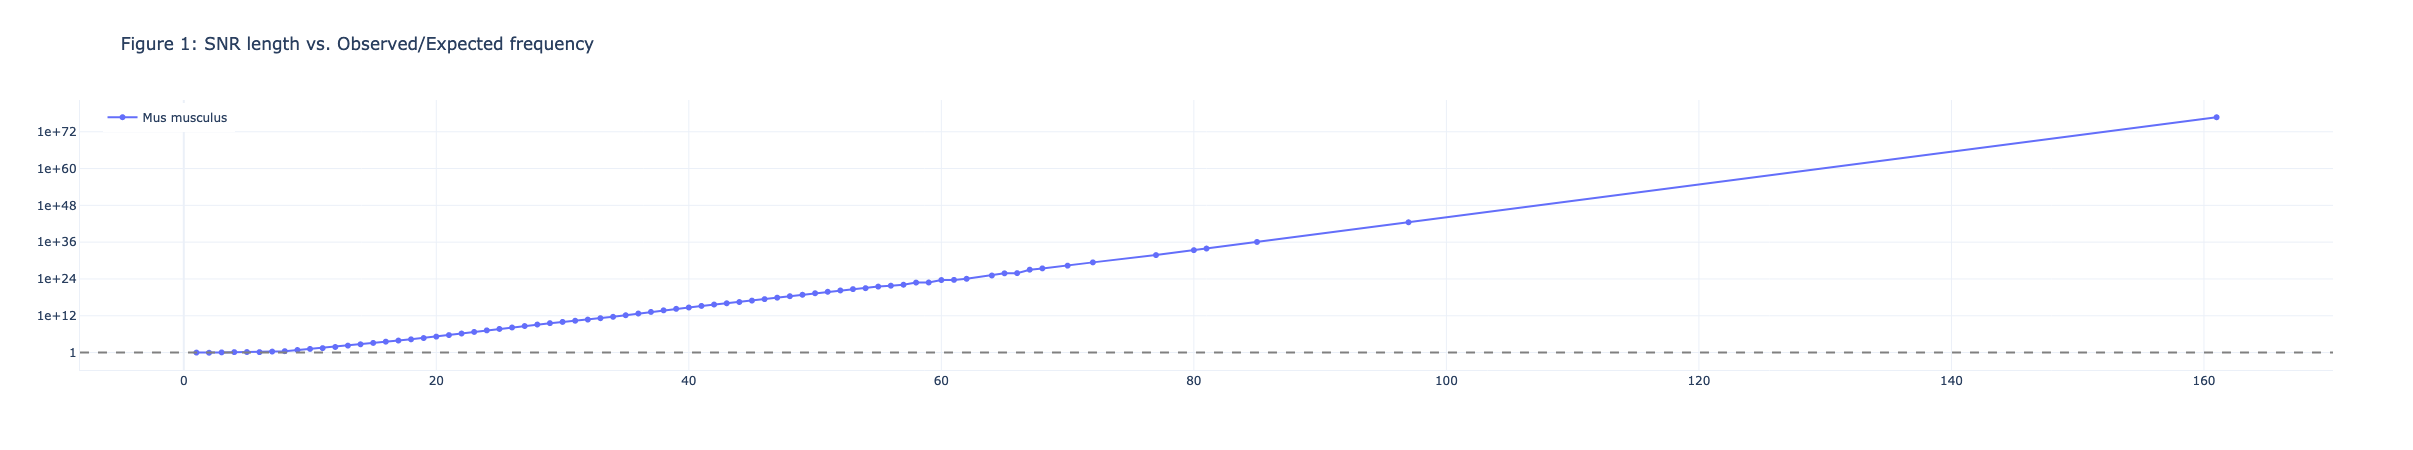

In [10]:
# Plot the graph of SNRcounts, log O/E vs. length
fig1 = go.Figure(data = go.Scatter(x = oe_df['SNR Length'], y = oe_df['O/E'], name = species, mode = 'lines+markers', showlegend = True),
                 layout = {'title': 'Figure 1: SNR length vs. Observed/Expected frequency',
                           'legend': {'xanchor': 'left', 'yanchor': 'top', 'x': 0.01, 'y': 0.99},
                           'shapes': [{'type': 'line', 'line': {'color': 'gray', 'width': 2, 'dash': 'dash'},
                                       # Add an "infinite" line where the x limits are determined by the relative "paper" ref
                                       'xref' : 'paper', 'x0': 0, 'x1': 1, 'y0': 1, 'y1': 1}],
                           'yaxis': {'exponentformat': 'e', 'type': 'log'}})
# max(oe_df['SNR Length'])
fig1.show()

## Figure 2: SNR feature composition

In [11]:
# Get the df of features represented among the SNRs
h_df = ana.SNRfeatureSets(lenToConcFeats)
xLabels = ana.getColNames(h_df)

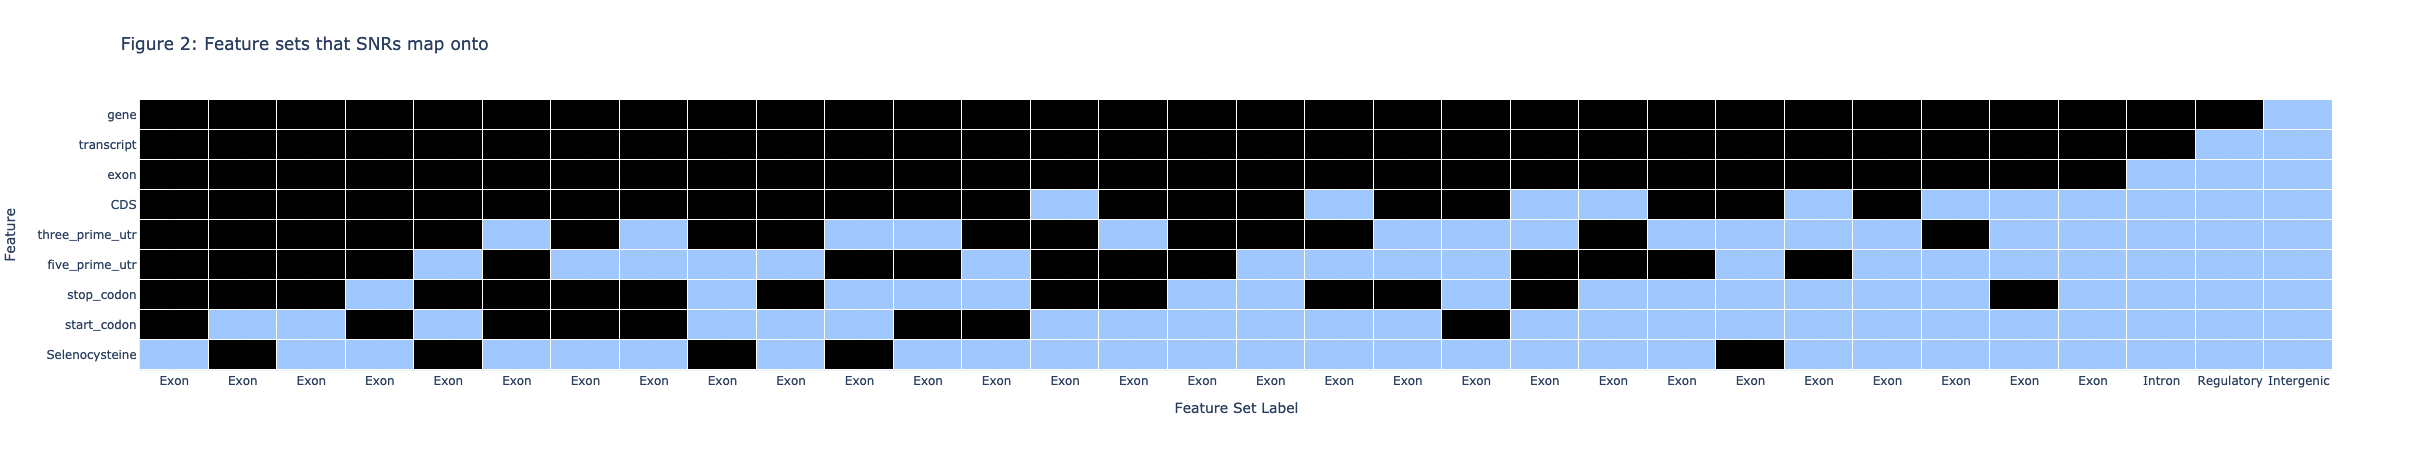

In [12]:
fig2 = go.Figure(data = go.Heatmap(y = list(h_df.index), z = h_df.to_numpy().astype(int), colorscale = 'Blackbody_r', xgap = 1, ygap = 1,
                                   showscale = False),
                 layout = {'title': 'Figure 2: Feature sets that SNRs map onto', 'yaxis': {'autorange': 'reversed', 'title': 'Feature'},
                           'xaxis': {'title': 'Feature Set Label', 'ticktext': xLabels, 'tickvals': list(range(32))}})

fig2.show()

## Figure 3: Proportions of SNRs by feature

In [13]:
# Get the proportions of labels in the SNR data by SNR length
p_df = ana.SNRlabelProps(lenToConcFeats)

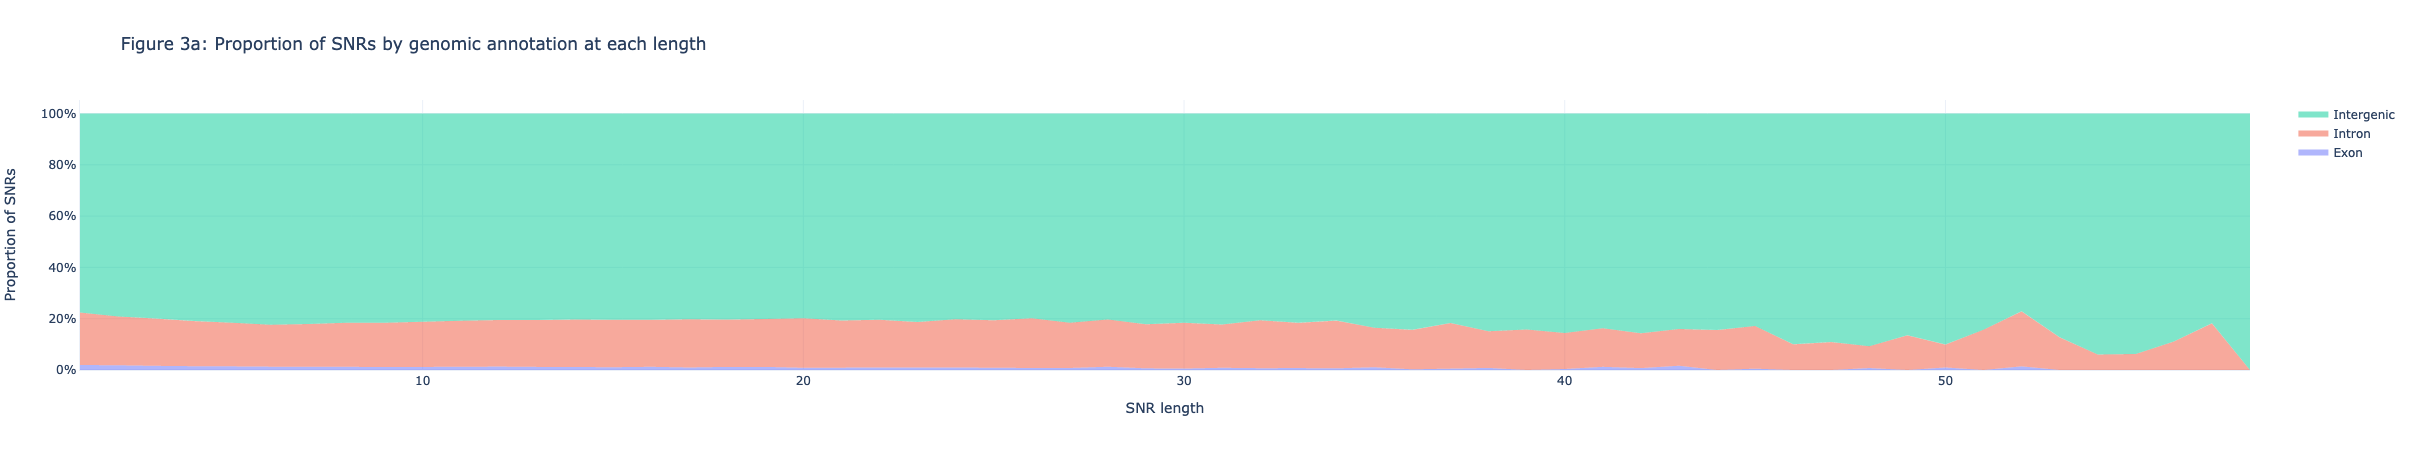

In [14]:
fig3a = go.Figure(data = [
    go.Scatter(x = list(p_df.index), y = p_df['Exon'], stackgroup = 'one', name = 'Exon', mode = 'none', groupnorm = 'percent'),
    go.Scatter(x = list(p_df.index), y = p_df['Intron'], stackgroup = 'one', name = 'Intron', mode = 'none', groupnorm = 'percent'),
    go.Scatter(x = list(p_df.index), y = p_df['Intergenic'], stackgroup = 'one', name = 'Intergenic', mode = 'none', groupnorm = 'percent')],
                 layout = {'title': 'Figure 3a: Proportion of SNRs by genomic annotation at each length',
                           'xaxis_title': 'SNR length', 'yaxis': {'title': 'Proportion of SNRs', 'ticksuffix': '%'}})
fig3a.show()

In [15]:
t_start = time.time()

# Normalize the measured SNR label proportions by the genomic proportions
df_norm = ana.normalizeLabels(p_df, out_strandedFeats, out_db = out_db, fasta = fasta)

det.howLongSince(t_start)

File loaded from /dartfs-hpc/rc/home/h/f002b9h/BoscoG/polyA/sequencing_data/refs/output/refdata-cellranger-mm10-3.0.0/strandedFeats.pkl
Measuring the size of the genome...
The total genome length is 2,730,871,774 bp.
0h:0m:33s elapsed


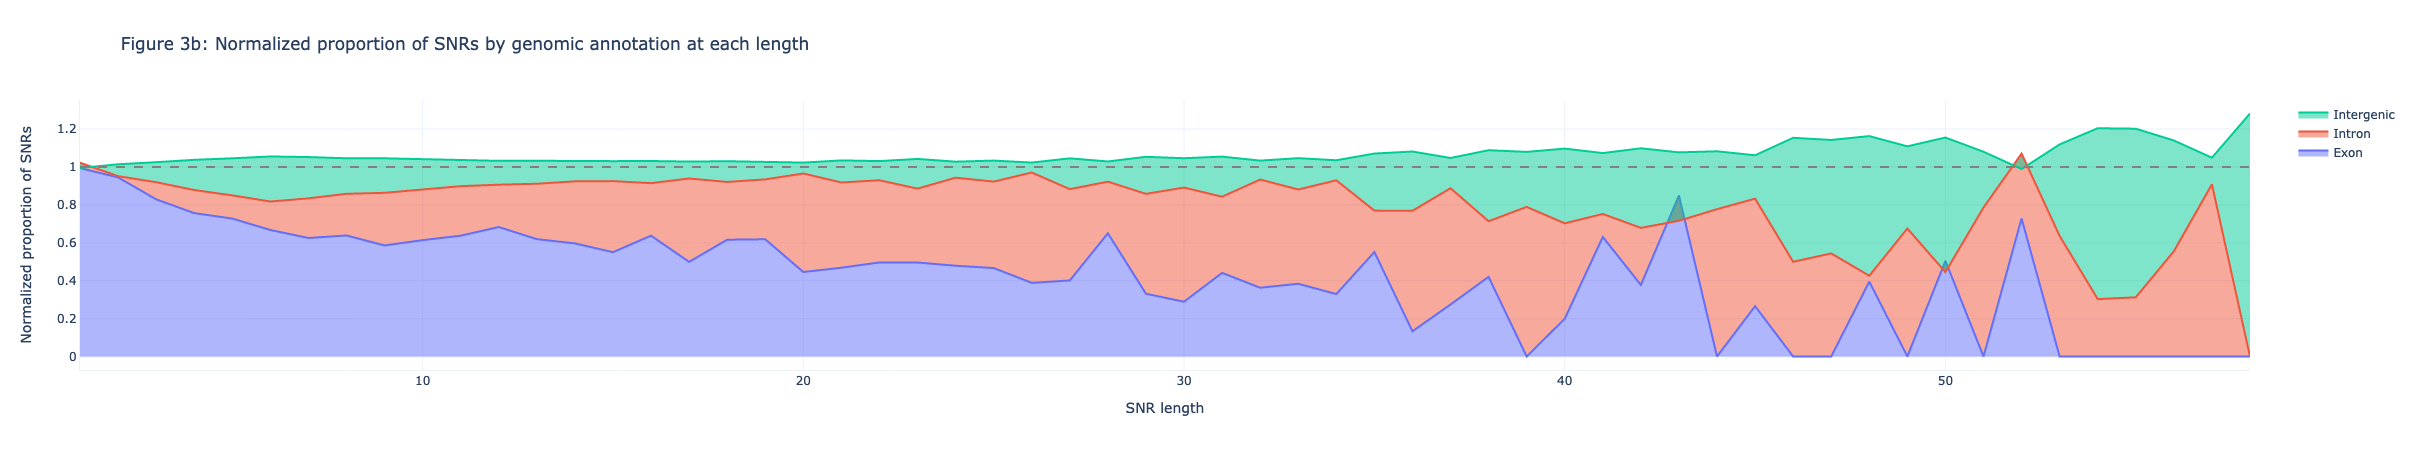

In [16]:
fig3b = go.Figure(data = [go.Scatter(x = list(df_norm.index), y = df_norm['Exon'], name = 'Exon', mode = 'lines', fill = 'tozeroy'),
                          go.Scatter(x = list(df_norm.index), y = df_norm['Intron'], name = 'Intron', mode = 'lines', fill = 'tonexty'),
                          go.Scatter(x = list(df_norm.index), y = df_norm['Intergenic'], name = 'Intergenic', mode = 'lines', fill = 'tonexty')],
                  layout = {'title': 'Figure 3b: Normalized proportion of SNRs by genomic annotation at each length',
                            'xaxis_title': 'SNR length', 'yaxis_title': 'Normalized proportion of SNRs',
                            'shapes': [{'type': 'line', 'line': {'color': 'gray', 'width': 2, 'dash': 'dash'},
                                        # Add an "infinite" line where the x limits are determined by the relative "paper" ref
                                        'xref' : 'paper', 'x0': 0, 'x1': 1, 'y0': 1, 'y1': 1}]})
fig3b.show()

## Figure 4: RNA-seq coverage around SNRs

In [17]:
# Filter the bam files for only reads aligned to feats on their respective strands, if not done before
for concordance in (True, False):
    seq.filterReads(exonicConc_bamfile if concordance else exonicDisc_bamfile,
                    out_db,
                    out_strandedFeats,
                    bamfile,
                    featType = bamFiltFeat,
                    concordant = concordance)
# !!! Now index the bam file(s), if not done before; in bash:
#  samtools index $exonic_bamfile

The filtered file already exists.
The filtered file already exists.


In [18]:
t_start = time.time()

# Get the coverage data for concordant and discordant reads separately
coverage = 2*[None]
outliers = 2*[None]
SNRCov_files = (out_SNRCovConc, out_SNRCovDisc)
SNROut_files = (out_SNROutConc, out_SNROutDisc)
bamfiles = (exonicConc_bamfile, exonicDisc_bamfile)

for i, concordance in enumerate((True, False)):
    coverage[i], outliers[i] = seq.getCovPerSNR(SNRCov_files[i],
                                                SNROut_files[i],
                                                lenToSNRs,
                                                out_db,
                                                out_strandedFeats,
                                                bamfiles[i],
                                                window = wind,
                                                concordant = concordance,
                                                log10Filter = log10Filter)

det.howLongSince(t_start)

File loaded from /dartfs-hpc/rc/home/h/f002b9h/BoscoG/polyA/sequencing_data/Harrison2019/output/SRR7695649/polyaf/SNRCovConc_2000-2.pkl
File loaded from /dartfs-hpc/rc/home/h/f002b9h/BoscoG/polyA/sequencing_data/Harrison2019/output/SRR7695649/polyaf/SNROutConc_2000-2.pkl
File loaded from /dartfs-hpc/rc/home/h/f002b9h/BoscoG/polyA/sequencing_data/Harrison2019/output/SRR7695649/polyaf/SNRCovDisc_2000-2.pkl
File loaded from /dartfs-hpc/rc/home/h/f002b9h/BoscoG/polyA/sequencing_data/Harrison2019/output/SRR7695649/polyaf/SNROutDisc_2000-2.pkl
0h:0m:5s elapsed


In [19]:
# Initiate the variables that don't change
labels = ('polyA', 'polyT')
colors = ('green', 'red')
# Extract the possible lengths
eligible_lengths_all = [k for k in list(coverage[0].keys()) + list(coverage[1].keys())
                        if any((coverage[0][k][0] != 0, coverage[1][k][0] != 0, outliers[0][k] != [], outliers[1][k] != []))]
# Input turned into individual widgets
w_cov = widgets.fixed(coverage)
w_outliers = widgets.fixed(outliers)
w_lengths = widgets.IntRangeSlider(value = [min(eligible_lengths_all), max(eligible_lengths_all)],
                                   min = min(eligible_lengths_all),
                                   max = max(eligible_lengths_all),
                                   step = 1,
                                   description = 'SNR lengths:',
                                   continuous_update = False,
                                   layout = widgets.Layout(width = '100%'))
w_YMax = widgets.IntText(value = 20, description = 'YMax:', layout = widgets.Layout(width = '150px'))
w_polyA = widgets.Checkbox(value = True, description = 'Poly(A)')
w_polyT = widgets.Checkbox(value = True, description = 'Poly(T)')
w_includeOutliers = widgets.Checkbox(value = True, description = 'Include outliers')
w_includeZeros = widgets.Checkbox(value = True, description = 'Include zeros')
w_fig4a = go.FigureWidget(data = [go.Scatter(x = tuple(range(int(-wind/2), int(wind/2))),
                                             name = labels[i],
                                             marker_color = colors[i],
                                             mode = 'lines',
                                             showlegend = True)
                                  for i in range(2)],
                          layout = {'title': 'Figure 4a: Normalized RNA-seq read coverage around SNRs of given lengths',
                                    'xaxis_title': 'Genomic distance from SNR (bp)',
                                    'yaxis': {'title': 'RNA-seq read coverage (O/E)', 'range': [0, w_YMax.value]},
                                    'autosize': True,
                                    'shapes': [{'type': 'line', 'line': {'color': 'gray', 'width': 2, 'dash': 'dash'},
                                                'xref': 'paper', 'x0': 0, 'x1': 1, 'yref': 'y', 'y0': 1, 'y1': 1},
                                               {'type': 'line', 'line': {'color': 'orange', 'width': 2, 'dash': 'dash'},
                                                'xref': 'x', 'x0': 0, 'x1': 0, 'yref' : 'paper', 'y0': 0, 'y1': 1}]})
#w_fig4a.layout.width = '100%'

# Figure-updating function that is being run based on the input; only the y values are changed
def showSNRcovSum(cov, outliers, lengths, includeOutliers, includeZeros):
    # Initiate the variables that need to be reset every time
    SNRCount = [0, 0]
    totalCoverage = [np.zeros((wind)), np.zeros((wind))]
    # Go over the aggregate & outlier coverage data
    for i in range(2):
        for length, (ct, zeros, arr) in cov[i].items():
            if length in range(lengths[0], lengths[1]+1):
                totalCoverage[i] += arr
                SNRCount[i] += ct
                if not includeZeros:
                    SNRCount[i] -= zeros
                # Go over all the outliers @ the given length & add them as well
                if includeOutliers:
                    for (snr, outArr) in outliers[i][length]:
                        # Add the outlier to the totals for overall coverage
                        totalCoverage[i] += outArr
                        SNRCount[i] += 1
        totalCoverage[i] = totalCoverage[i] / SNRCount[i] if SNRCount[i] != 0 else 0
        # Update the traces on the go
        w_fig4a.update_traces(y = totalCoverage[i], selector = {'name': labels[i]})
    
# Simple function to only update the displayed figure without having to recalculate the input
def updateFig4a(ymax, polyA, polyT):
    with w_fig4a.batch_update():
        w_fig4a.layout.yaxis.range = [0, ymax]
        w_fig4a.data[0].visible = polyA
        w_fig4a.data[1].visible = polyT
# Tie these elements interactively together
widgets.interactive_output(updateFig4a, {'ymax': w_YMax, 'polyA': w_polyA, 'polyT': w_polyT})

# UI aligned into widgets
ui = widgets.Box(
    children = [w_lengths,
                widgets.Box([w_YMax, w_polyA, w_polyT, w_includeOutliers, w_includeZeros], layout = widgets.Layout(margin = '5px 0px 10px 0px')),
                w_fig4a],
    layout = widgets.Layout(flex_flow = 'column'))
# Intereactive output, wrapped in a function with its input arguments
out = widgets.interactive_output(showSNRcovSum, {'cov': w_cov,
                                                 'outliers': w_outliers,
                                                 'lengths': w_lengths,
                                                 'includeOutliers': w_includeOutliers,
                                                 'includeZeros': w_includeZeros})
# Display the UI with the output
display(ui, out)

Box(children=(IntRangeSlider(value=(5, 97), continuous_update=False, description='SNR lengths:', layout=Layout…

Output()

In [20]:
# Plot the coverage by length, including the outliers
As = set(m for m in coverage[0].keys() if coverage[0][m][0] != 0 or outliers[0][m] != [])
Ts = set(n for n in coverage[1].keys() if coverage[1][n][0] != 0 or outliers[1][n] != [])
eligible_lengths_each = ['{}{}'.format('A', k) for k in sorted(list(As))]+['{}{}'.format('T', l) for l in sorted(list(Ts))]
colors_rgb = [tuple(mcols.hsv_to_rgb((col, 0.6, 0.9))) for col in np.linspace(0, 0.75, num = len(eligible_lengths_each))]
color_dict = {el_len : colors_rgb[i] for i, el_len in enumerate(eligible_lengths_each)}
e_labels = ('A', 'T')

# Input turned into individual widgets
e_lengths = widgets.IntRangeSlider(value = [min(As | Ts), max(As | Ts)],
                                   min = min(As | Ts),
                                   max = max(As | Ts),
                                   step = 1,
                                   description = 'SNR lengths:',
                                   continuous_update = False,
                                   layout = widgets.Layout(width = '100%'))
e_YMax = widgets.IntText(value = 120, description = 'YMax:', layout = widgets.Layout(width = '150px'))
e_polyA = widgets.Checkbox(value = True, description = 'Poly(A)')
e_polyT = widgets.Checkbox(value = True, description = 'Poly(T)')
e_includeOutliers = widgets.Checkbox(value = True, description = 'Include outliers')
e_includeZeros = widgets.Checkbox(value = True, description = 'Include zeros')
e_fig4b = go.FigureWidget(data = [go.Scatter(x = tuple(range(int(-wind/2), int(wind/2))),
                                             name = n,
                                             marker_color = 'rgb{}'.format(col),
                                             mode = 'lines')
                                  for n, col in color_dict.items()],
                          layout = {'title': 'Figure 4b: Normalized RNA-seq read coverage around SNRs of each length',
                                    'xaxis_title': 'Genomic distance from SNR (bp)',
                                    'yaxis_title': 'RNA-seq read coverage (O/E)', 'yaxis_range' : [0, e_YMax.value],
                                    'shapes': [{'type': 'line', 'line': {'color': 'gray', 'width': 2, 'dash': 'dash'},
                                                'xref' : 'paper', 'x0': 0, 'x1': 1, 'yref' : 'y', 'y0': 1, 'y1': 1},
                                               {'type': 'line', 'line': {'color': 'orange', 'width': 2, 'dash': 'dash'},
                                                'xref' : 'x', 'x0': 0, 'x1': 0, 'yref' : 'paper', 'y0': 0, 'y1': 1}]})

# Function that is being run
def showSNRcovEach(cov, outliers, includeOutliers, includeZeros):
    # Initiate the variables that have to be reset every time this funciton is run
    coverageEach = ({},{})
    e_traces = []
    # Go over the aggregate & outlier coverage data
    for i in range(2):
        for length, (ct, zeros, arr) in cov[i].items():
            label_len = '{}{}'.format(e_labels[i], length)
            SNRcount = 0
            totalCoverage = np.zeros((wind))
            SNRcount += ct
            totalCoverage += arr
            if not includeZeros:
                SNRcount -= zeros
            if includeOutliers:
                # Go over all the outliers @ the given length & add them as well (if they exist)
                for (snr, outArr) in outliers[i][length]:
                    # Add the outlier to the coverage
                    totalCoverage += outArr
                    SNRcount += 1
            totalCoverage = totalCoverage / SNRcount if SNRcount != 0 else 0
            # Follow the same rules for inclusion as above for eligible lengths
            if label_len in eligible_lengths_each:
                # Update the traces on the go
                e_fig4b.update_traces(y = totalCoverage, selector = {'name': label_len})

# Simple function to only update the displayed figure without having to recalculate the input
def updateFig4b(lengths, polyA, polyT):
    make_visible = set('{}{}'.format(e_labels[i], length)
                       for i, poly in enumerate((polyA, polyT))
                       for length in (As, Ts)[i]
                       if poly and length in range(lengths[0], lengths[1]+1))
    with e_fig4b.batch_update():
        e_fig4b.for_each_trace(lambda trace: trace.update(visible = trace.name in make_visible))
# Tie these elements interactively together
widgets.interactive_output(updateFig4b, {'lengths': e_lengths, 'polyA': e_polyA, 'polyT': e_polyT})

def updateFig4bY(ymax):
    e_fig4b.layout.yaxis.range = [0, ymax]
widgets.interactive_output(updateFig4bY, {'ymax': e_YMax})

# UI aligned into widgets
ui_e = widgets.Box([e_lengths,
                    widgets.Box([e_YMax, e_polyA, e_polyT, e_includeOutliers, e_includeZeros], layout = widgets.Layout(margin = '5px 0px 10px 0px')),
                    e_fig4b],
                   layout = widgets.Layout(flex_flow = 'column'))
# Intereactive output, wrapped in a function with its input arguments
out_e = widgets.interactive_output(showSNRcovEach, {'cov': w_cov,
                                                    'outliers': w_outliers,
                                                    'includeOutliers': e_includeOutliers,
                                                    'includeZeros': e_includeZeros})
# Display the UI with the output
display(ui_e, out_e)

Box(children=(IntRangeSlider(value=(5, 97), continuous_update=False, description='SNR lengths:', layout=Layout…

Output()

## Figure 5: RNA-seq coverage around Transcript ends

In [21]:
# Get the coverage around the end of all transcripts
t_start = time.time()

normCov = seq.getCovPerTran(out_TranCov,
                            out_db,
                            out_strandedFeats,
                            exonicConc_bamfile,
                            window = wind)

det.howLongSince(t_start)

File loaded from /dartfs-hpc/rc/home/h/f002b9h/BoscoG/polyA/sequencing_data/Harrison2019/output/SRR7695649/polyaf/TranCov_2000.pkl
0h:0m:0s elapsed


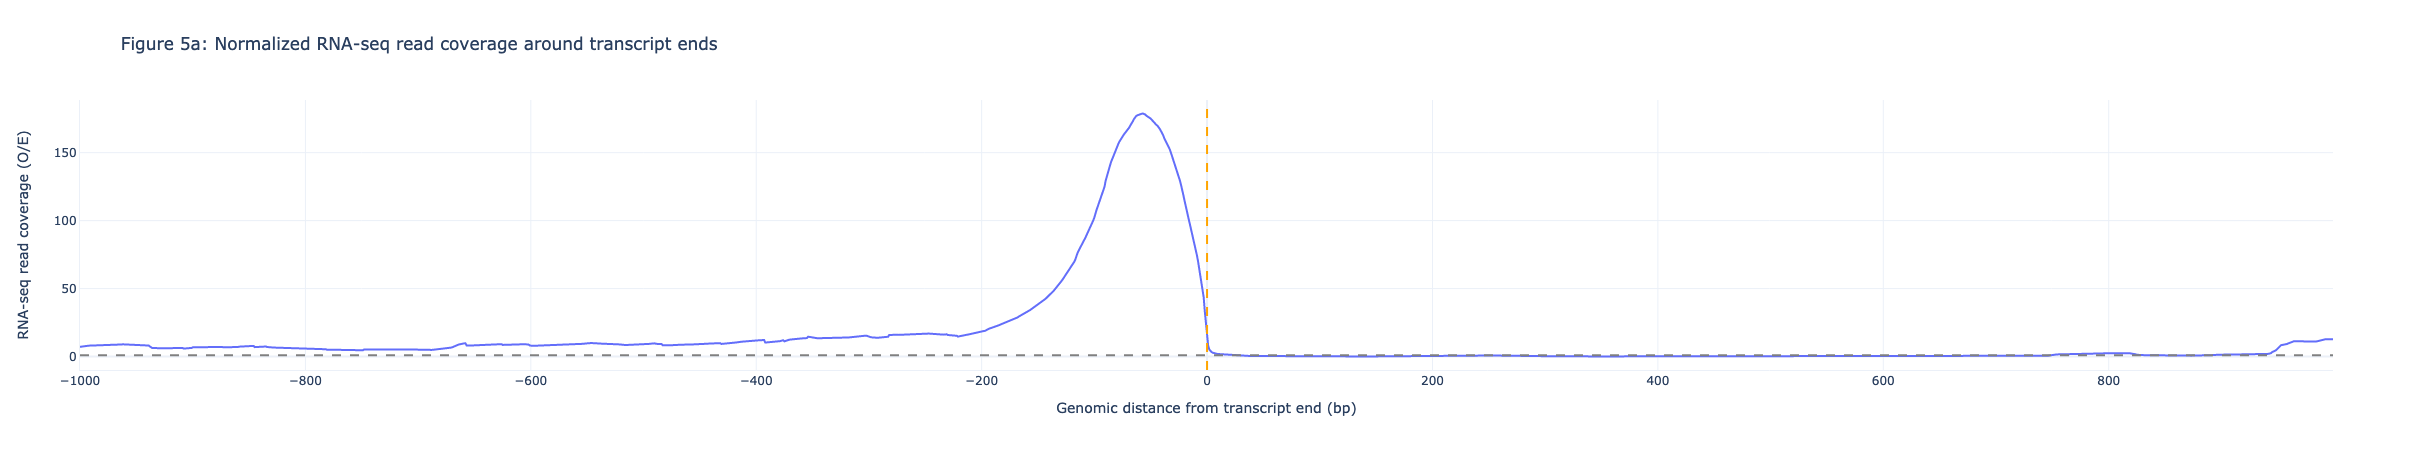

In [22]:
fig5a = go.Figure(data = [go.Scatter(x = tuple(range(int(-wind/2), int(wind/2))), y = normCov, mode = 'lines')],
                  layout = {'title': 'Figure 5a: Normalized RNA-seq read coverage around transcript ends',
                            'xaxis_title': 'Genomic distance from transcript end (bp)',
                            'yaxis_title': 'RNA-seq read coverage (O/E)',
                            'shapes': [{'type': 'line', 'line': {'color': 'gray', 'width': 2, 'dash': 'dash'},
                                        'xref' : 'paper', 'x0': 0, 'x1': 1, 'yref' : 'y', 'y0': 1, 'y1': 1},
                                       {'type': 'line', 'line': {'color': 'orange', 'width': 2, 'dash': 'dash'},
                                        'xref' : 'x', 'x0': 0, 'x1': 0, 'yref' : 'paper', 'y0': 0, 'y1': 1}]})
fig5a.show()

## Figure 6: Non-canonical RNA-seq coverage for each gene

In [23]:
# Scan for genes whose coverage is beyond the exon-wise end of transcripts
t_start = time.time()

nonCanCovGenes = seq.getNonCanCovGenes(out_NonCanCovGenes,
                                       lenToSNRs,
                                       out_db,
                                       exonicConc_bamfile,
                                       lastBP = lastBP,
                                       covThreshold = covThreshold,
                                       minLen = minLen)

det.howLongSince(t_start)

File loaded from /dartfs-hpc/rc/home/h/f002b9h/BoscoG/polyA/sequencing_data/Harrison2019/output/SRR7695649/polyaf/NonCanCovGenes_250-0.05-0.pkl
0h:1m:22s elapsed


In [35]:
SNR_lens = {l for g in nonCanCovGenes for l in g.SNRs.keys()}

# Input turned into individual widgets
g_data = widgets.fixed(nonCanCovGenes)
g_lastBP = widgets.fixed(lastBP)
g_geneID = widgets.Dropdown(description = 'Gene:', continuous_update = False)
g_prop_l = widgets.Label(value = '%Non-canonical:', layout = widgets.Layout(width = '125px'))
g_prop = widgets.FloatSlider(value = 0.05,
                             min = 0.05,
                             max = 1,
                             step = 0.01,
                             readout_format = '.0%',
                             continuous_update = False)
g_SNRlen = widgets.IntSlider(value = 15,
                             min = min(SNR_lens),
                             max = max(SNR_lens),
                             step = 1,
                             continuous_update = False)
g_SNRlen_l = widgets.Label(value = 'Min SNR length:', layout = widgets.Layout(width = '115px'))
# Initialize the fig6 widget
fig6 = go.FigureWidget()
# Figure grid & margin sizes in px
top = 140
bottom = 20
main = 400
subp = 20
gap = 0

# Plot coverage for each gene identified to be potentially non-canonically covered
def showGeneCov(listOfGenes, geneID, minSNRlen, p, lastBP):
    
    nGene = listOfGenes[geneID]
    gene0start = nGene.geneFeat.start - 1     # Conversion from 1-based => 0-based
    gene0end = nGene.geneFeat.end             # Conversion from 1-based => 0-based
    numTranscripts = len(nGene.trans)
    geneLen = gene0end - gene0start
    
    # Make a list of shapes to be added later at once as a part of batch update
    shapes = []
    annotations = []
    # Add transcript ends to the first plot
    for ending in nGene.endings:
        shapes.append(go.layout.Shape(type = 'rect', line = {'color': 'lightgray', 'width': 1}, fillcolor = 'lightgray', layer = 'below',
                       xref = 'x', x0 = ending[0], x1 = ending[1], yref = 'paper', y0 = 0, y1 = 1))
    # Add the SNRs into the first plot
    for length, (_, snrs) in nGene.SNRs.items():
        if length >= minSNRlen:
            for snr in snrs:
                shapes.append(go.layout.Shape(type = 'rect', line = {'color': 'lightsalmon', 'width': 1}, fillcolor = 'lightsalmon', opacity = 0.2, layer = 'below',
                                              xref = 'x',
                                              x0 = snr.start - lastBP if nGene.geneFeat.strand == '+' else snr.end,
                                              x1 = snr.start if nGene.geneFeat.strand == '+' else snr.end + lastBP,
                                              yref = 'paper', y0 = 0, y1 = 1))
    # Add the name of the gene as an annotation
    annotations.append(go.layout.Annotation(text = '{} (chr{}{})'.format(nGene.geneFeat.id, nGene.geneFeat.seqid, nGene.geneFeat.strand), showarrow = False,
                                            xref = 'paper', xanchor = 'left' if nGene.geneFeat.strand == '+' else 'right', x = 0.02 if nGene.geneFeat.strand == '+' else 0.98,
                                            # Anchor the gene name 20 px from top and always towards the beginning of the gene (x-wise)
                                            yref = 'paper', yanchor = 'top', y = (numTranscripts*subp + main - 20) / (numTranscripts*subp + main),
                                            bgcolor = 'white', opacity = 0.6, font = {'size': 15, 'color': 'black'}))
    
    # Do all the figure updates at once
    with fig6.batch_update():
        # Replace the data
        fig6.data = []
        # Add the coverage data (which is technically the only data in this figure)
        fig6.add_trace(go.Scatter(x = list(range(gene0start, gene0end)),
                                  y = nGene.cov,
                                  mode = 'lines',
                                  xaxis = 'x',
                                  yaxis = 'y1'))
        # The layout needs to be completely reset every time in order to remove any unneeded yaxes
        fig6.layout = {'title': 'Figure 6: Non-canonical RNA-seq coverage and SNR distribution for each gene',
                       'margin': {'t': top, 'b': bottom},
                       'height': top + bottom + numTranscripts*subp + main}
        # Initiate the first, main axis
        fig6.layout.yaxis1 = {'title': 'Read coverage',
                              'anchor': 'x',
                              'domain': [numTranscripts*subp / (numTranscripts*subp + main), 1],
                              'fixedrange': True,
                              'tickformat': ',d',
                              'automargin': False,  # A workaround to make the tickformat work
                              'showline': False}
        # Add the xaxis properties last in order to keep the title at the very top
        fig6.layout.xaxis = {'title': {'text': 'Chromosome coordinates (bp)', 'standoff': 0}, 'side': 'top', 'showline': False}
        # Add the shapes for each transcript into their respective layout axes
        for i, t in enumerate(nGene.trans):
            # Determine the color of this transript
            col = 'green' if t.geneID == nGene.geneFeat.id else 'red'
            # Add a new y axis for this transcript
            fig6.layout['yaxis{}'.format(i+2)] = {'anchor': 'x',
                                                  'range': [-2, 2] ,
                                                  'domain': [i*subp / (numTranscripts*subp + main), ((i+1)*subp - gap) / (numTranscripts*subp + main)],
                                                  'fixedrange': True, 'visible': False, 'zeroline': False, 'showgrid': False}
            # Add the transcript backbone
            shapes.append(go.layout.Shape(type = 'line', line = {'color': 'mediumseagreen', 'width': 3},
                                          xref = 'x', x0 = t.start, x1 = t.end, yref = 'y{}'.format(i+2), y0 = 0, y1 = 0))
#             annotations.append(go.layout.Annotation(ax = t.start if nGene.geneFeat.strand == '+' else t.end, ay = 0,
#                                                     axref = 'x', ayref = 'y{}'.format(i+2),
#                                                     x = t.end if nGene.geneFeat.strand == '+' else t.start, y = 0,
#                                                     xref = 'x', yref = 'y{}'.format(i+2),
#                                                     # Ensure that the arrow tail is flush
#                                                     xanchor = 'right' if nGene.geneFeat.strand == '+' else 'left',
#                                                     showarrow = True, arrowhead = 3, arrowwidth = 1.5, arrowcolor = col))
            for e in t.exons:
                shapes.append(go.layout.Shape(type = 'rect', line = {'color': 'mediumseagreen', 'width': 1}, fillcolor = 'mediumseagreen',
                                              xref = 'x', x0 = e[0], x1 = e[1], yref = 'y{}'.format(i+2), y0 = -1, y1 = 1))
        # Add the previously curated lists of shapes and annotations as tuples
        fig6.layout.shapes = tuple(shapes)
        fig6.layout.annotations = tuple(annotations)

def filterGenes(listOfGenes, p, minSNRlen):
    # Save the current value
    val = g_geneID.value
    # Filter the genes base on the input
    # Note: index & value from enumerate() have to flip to create the necessary (key, value) pairs
    g_geneID.options = [(g.geneFeat.id, i) for i, g in enumerate(listOfGenes)
                        if sum(prop for length, (prop, _) in g.SNRs.items() if length >= minSNRlen) >= p]
    # Set the prior value after filtering, if present
    if val in (v for k, v in g_geneID.options): g_geneID.value = val
# Widget to filter the list of genes in the g_geneID widget
widgets.interactive_output(filterGenes, {'listOfGenes' : g_data, 'p' : g_prop, 'minSNRlen' : g_SNRlen})

# UI aligned into widgets
ui_g = widgets.Box([widgets.Box([g_prop_l, g_prop, g_SNRlen_l, g_SNRlen, g_geneID], layout = widgets.Layout(margin = '0px 0px 10px 0px')), fig6],
                   layout = widgets.Layout(flex_flow = 'column'))
# Intereactive output, wrapped in a function with its input arguments
out_g = widgets.interactive_output(showGeneCov, {'listOfGenes': g_data,
                                                 'geneID': g_geneID,
                                                 'minSNRlen': g_SNRlen,
                                                 'p': g_prop,
                                                 'lastBP': g_lastBP})
# Display the UI with the output
display(ui_g, out_g)

# Add filter by minimum coverage, ending length slider(?), show SNR toggle

Box(children=(Box(children=(Label(value='%Non-canonical:', layout=Layout(width='125px')), FloatSlider(value=0.…

Output()

## Figure 7: Optimization of RNA-seq Exon-wise Transcript End Length

In [25]:
# Get data for an ROC
t_start = time.time()

transEndROC = seq.getTransEndROC(out_transEndROC,
                                 out_transBaselineData,
                                 out_db,
                                 bamfile,
                                 endLenMin,
                                 endLenMax,
                                 product = product)

det.howLongSince(t_start)

File loaded from /dartfs-hpc/rc/home/h/f002b9h/BoscoG/polyA/sequencing_data/Harrison2019/output/SRR7695649/polyaf/transEndROC_50-500-False.pkl
0h:0m:1s elapsed


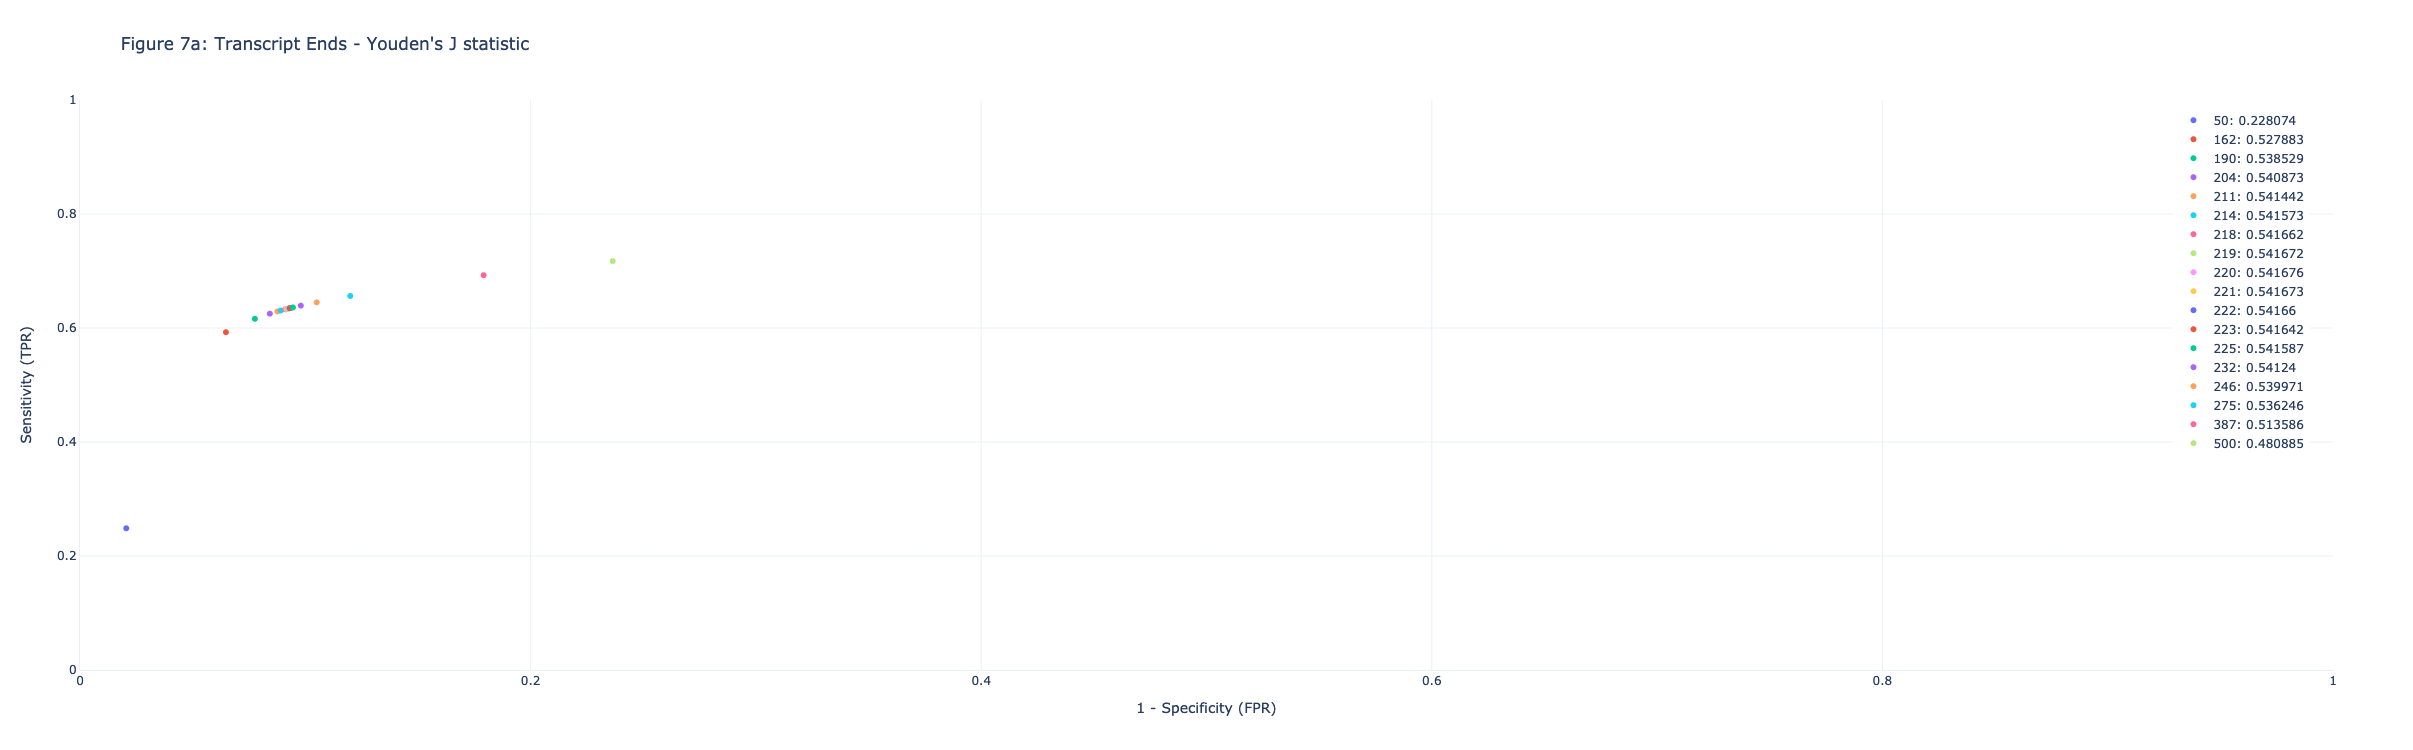

In [26]:
fig7a = go.Figure(data = [go.Scatter(x = (1 - transEndROC[key][1], ), y = (transEndROC[key][0], ), mode = 'markers',
                                     name = '{}: {}'.format(key, round(transEndROC[key][0]*transEndROC[key][1] if product else transEndROC[key][0]+transEndROC[key][1]-1, 6)))
                          for key in sorted(transEndROC.keys())],
                  layout = {'title': 'Figure 7a: Transcript Ends - {}'.format(stat),
                            'xaxis': {'title': '1 - Specificity (FPR)', 'range' : [0, 1]},
                            'yaxis': {'title': 'Sensitivity (TPR)', 'range' : [0, 1]},
                            'legend': {'xanchor': 'right', 'x': 0.99, 'yanchor': 'top', 'y': 0.99},
                            'width': 750, 'height': 750})
fig7a.show()

In [27]:
# Get data for an snr ROC: What is the proportion of coverage accounted for by SNRs of given minimal length in genes in which they occur?
t_start = time.time()

optEndLen = max(transEndROC, key = lambda l: transEndROC[l][0] * transEndROC[l][1] if product else transEndROC[l][0] + transEndROC[l][1] - 1)

snrROC = seq.getSNRcovByGene(optEndLen, lenToSNRs, out_snrROC, out_transBaselineData, out_db, bamfile)

det.howLongSince(t_start)

File loaded from /dartfs-hpc/rc/home/h/f002b9h/BoscoG/polyA/sequencing_data/Harrison2019/output/SRR7695649/polyaf/snrROC_False.pkl
0h:0m:0s elapsed


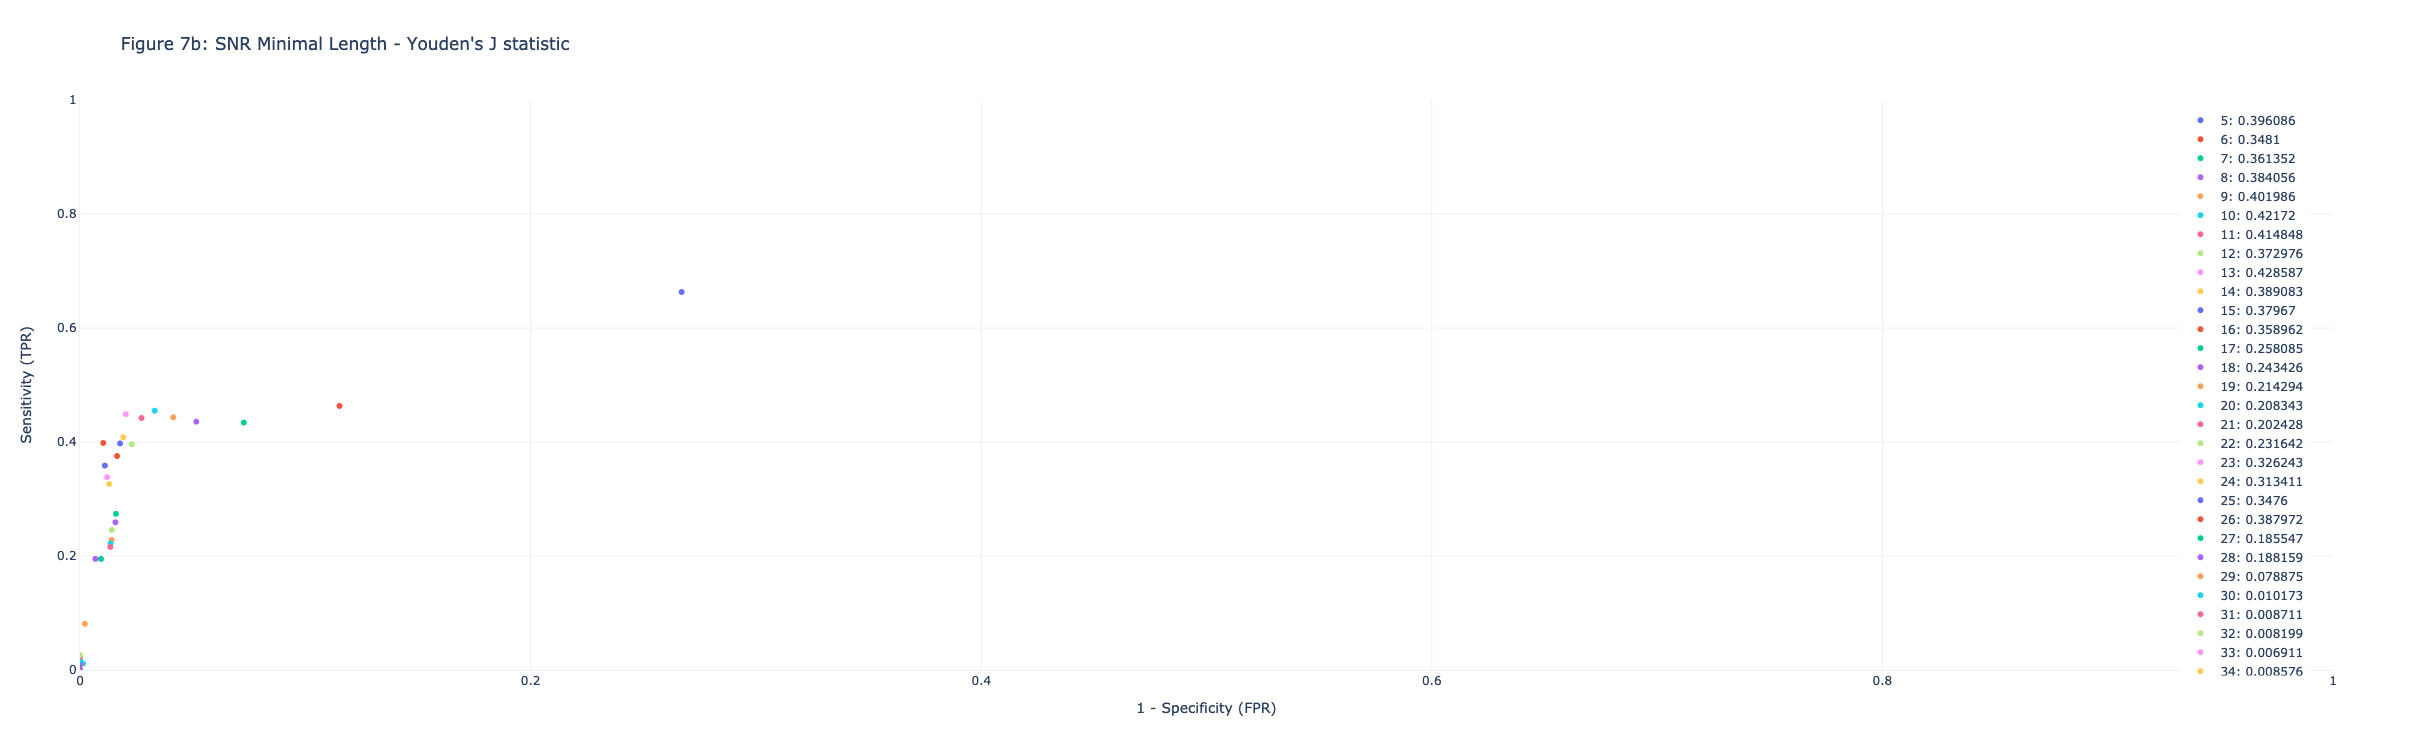

In [28]:
fig7b = go.Figure(data = [go.Scatter(x = (1 - snrROC[key][1], ), y = (snrROC[key][0], ), mode = 'markers',
                                     name = '{}: {}'.format(key, round(snrROC[key][0]*snrROC[key][1] if product else snrROC[key][0]+snrROC[key][1]-1, 6)))
                          for key in sorted(snrROC.keys())],
                  layout = {'title': 'Figure 7b: SNR Minimal Length - {}'.format(stat),
                            'xaxis': {'title': '1 - Specificity (FPR)', 'range' : [0, 1]},
                            'yaxis': {'title': 'Sensitivity (TPR)', 'range' : [0, 1]},
                            'legend': {'xanchor': 'right', 'x': 0.99, 'yanchor': 'top', 'y': 0.99},
                            'width': 750, 'height': 750})
fig7b.show()

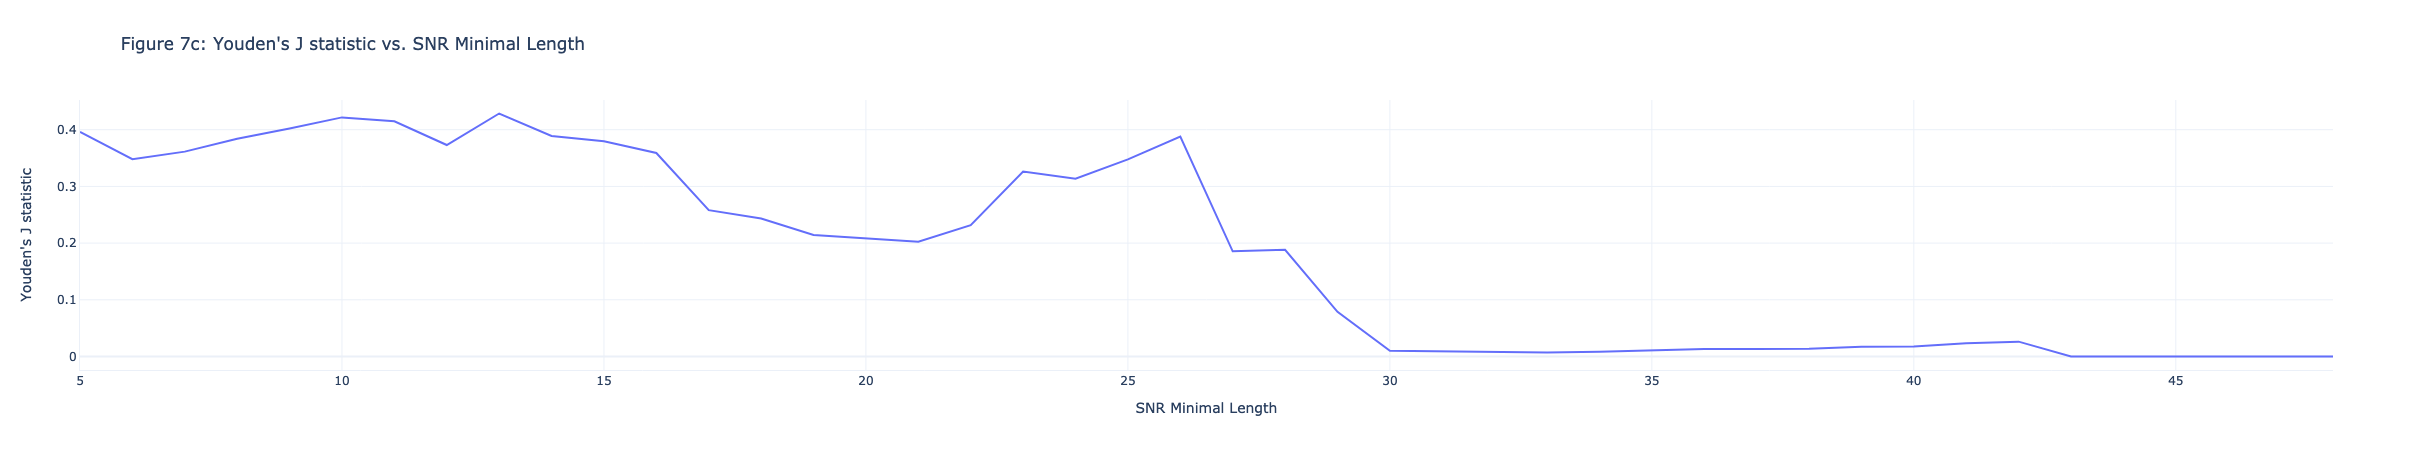

In [29]:
fig7c = go.Figure(data = [go.Scatter(x = sorted(snrROC.keys()),
                                     y = tuple(snrROC[key][0]*snrROC[key][1] if product else snrROC[key][0]+snrROC[key][1]-1 for key in sorted(snrROC.keys())))],
                  layout = {'title': 'Figure 7c: {} vs. SNR Minimal Length'.format(stat),
                            'xaxis_title': 'SNR Minimal Length', 'yaxis_title': stat})
fig7c.show()

## Figure 8: SNR Content vs. Non-Canonical Coverage Per Gene

In [30]:
# Get per gene coverage & SNR statistics
t_start = time.time()

minSNRlen = max(snrROC, key = lambda l: snrROC[l][0] * snrROC[l][1] if product else snrROC[l][0] + snrROC[l][1] - 1)

statsByGene = seq.getStatsByGene(optEndLen, minSNRlen, lenToSNRs, out_geneStats, out_db, out_transBaselineData, bamfile)

det.howLongSince(t_start)

File saved to /dartfs-hpc/rc/home/h/f002b9h/BoscoG/polyA/sequencing_data/Harrison2019/output/SRR7695649/polyaf/geneStats_False.pkl
0h:6m:11s elapsed


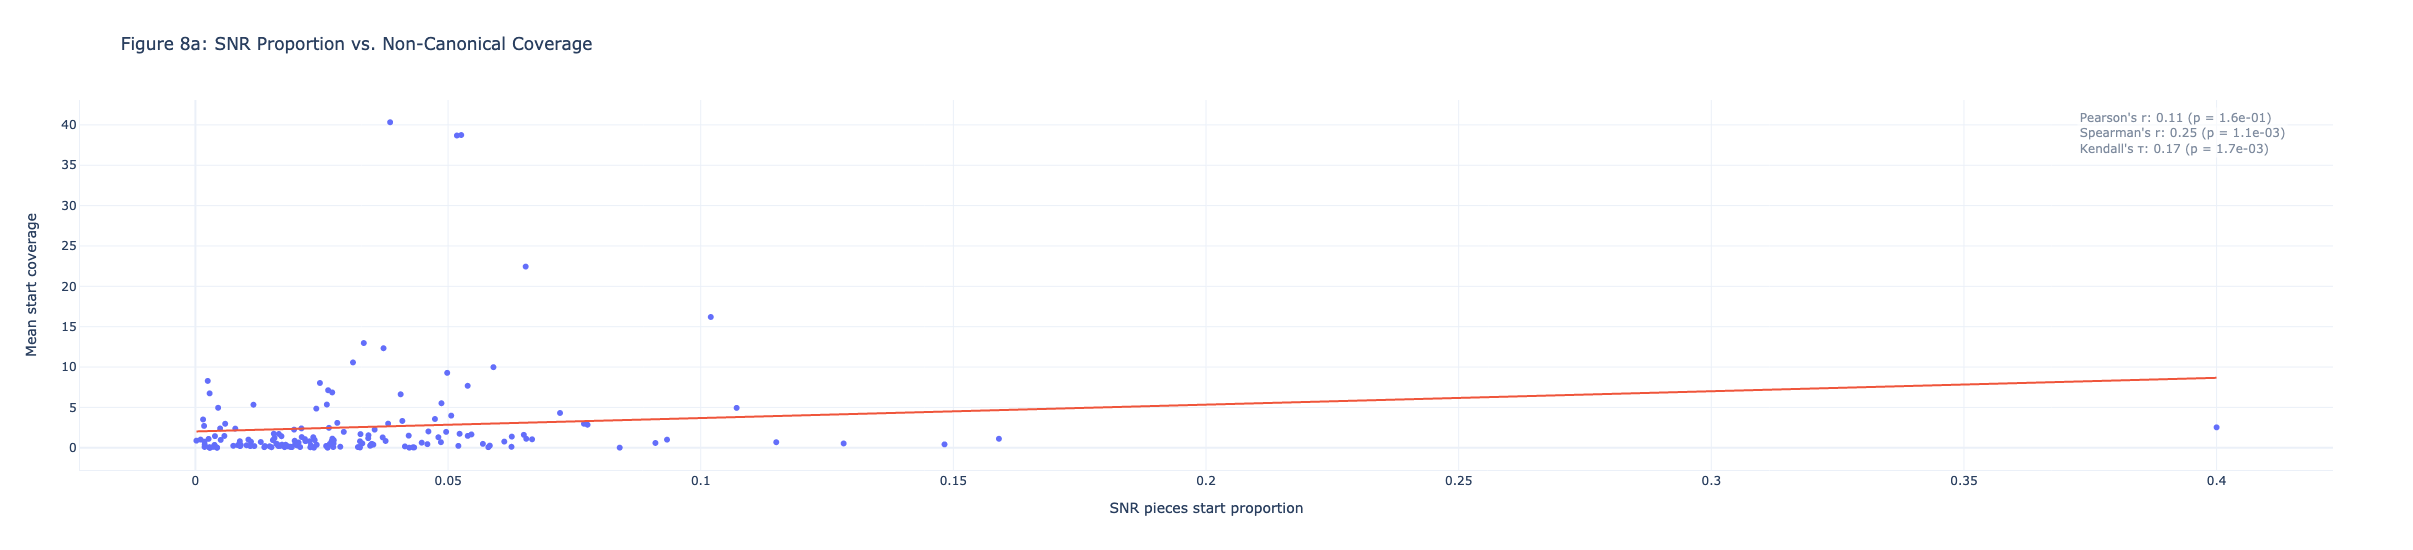

In [31]:
x_a = np.array([stats[6]/stats[3] for stats in statsByGene.values() if stats[2] != 0 and stats[6] != 0])
y_a = np.array([stats[2]/stats[3] for stats in statsByGene.values() if stats[2] != 0 and stats[6] != 0])
m_a, b_a = np.polyfit(x_a, y_a, 1)

corrs = (sps.pearsonr(x_a, y_a), sps.spearmanr(x_a, y_a), sps.kendalltau(x_a, y_a))

fig8a = go.Figure(data = [go.Scatter(x = x_a, y = y_a, mode = 'markers'),
                          go.Scatter(x = x_a, y = m_a * x_a + b_a, mode = 'lines')],
                  layout = {'title': 'Figure 8a: SNR Proportion vs. Non-Canonical Coverage',
                            'xaxis_title': 'SNR pieces start proportion', 'yaxis_title': 'Mean start coverage',
                            'height': 550, 'width': 550, 'showlegend': False,
                            'annotations': [go.Annotation(
                                text = "Pearson's r: {:.2f} (p = {:.1e})<br>Spearman's r: {:.2f} (p = {:.1e})<br>Kendall's &#964;: {:.2f} (p = {:.1e})".format(
                                    *[i for c in corrs for i in c]),
                                showarrow = False, align = 'left', bgcolor = 'white', opacity = 0.6,
                                xref = 'paper', xanchor = 'right', x = 0.98, yref = 'paper', yanchor = 'top', y = 0.98)]})
fig8a.show()

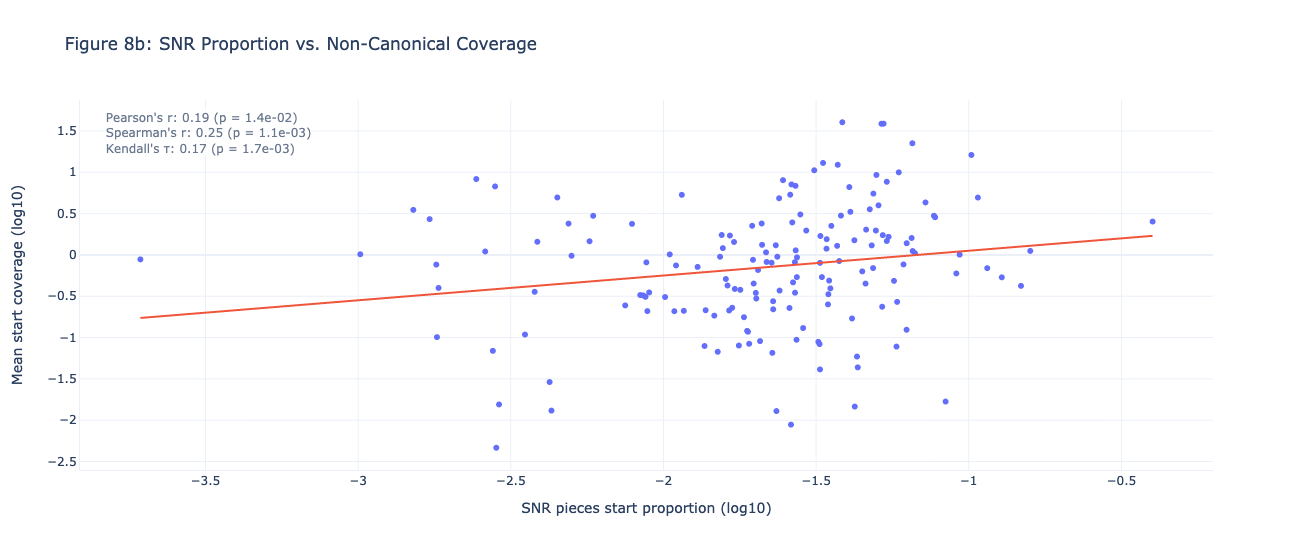

In [32]:
x_b = np.log10(np.array([stats[6]/stats[3] for stats in statsByGene.values() if stats[2] != 0 and stats[6] != 0]))
y_b = np.log10(np.array([stats[2]/stats[3] for stats in statsByGene.values() if stats[2] != 0 and stats[6] != 0]))
m_b, b_b = np.polyfit(x_b, y_b, 1)

corrs = (sps.pearsonr(x_b, y_b), sps.spearmanr(x_b, y_b), sps.kendalltau(x_b, y_b))

fig8b = go.Figure(data = [go.Scatter(x = x_b, y = y_b, mode = 'markers'),
                          go.Scatter(x = x_b, y = m_b * x_b + b_b, mode = 'lines')],
                  layout = {'title': 'Figure 8b: SNR Proportion vs. Non-Canonical Coverage',
                            'xaxis_title': 'SNR pieces start proportion (log10)', 'yaxis_title': 'Mean start coverage (log10)',
                            'height': 550, 'width': 550, 'showlegend': False,
                            'annotations': [go.Annotation(
                                text = "Pearson's r: {:.2f} (p = {:.1e})<br>Spearman's r: {:.2f} (p = {:.1e})<br>Kendall's &#964;: {:.2f} (p = {:.1e})".format(
                                    *[i for c in corrs for i in c]),
                                showarrow = False, align = 'left', bgcolor = 'white', opacity = 0.7,
                                xref = 'paper', xanchor = 'left', x = 0.02, yref = 'paper', yanchor = 'top', y = 0.98)]})
fig8b.show()

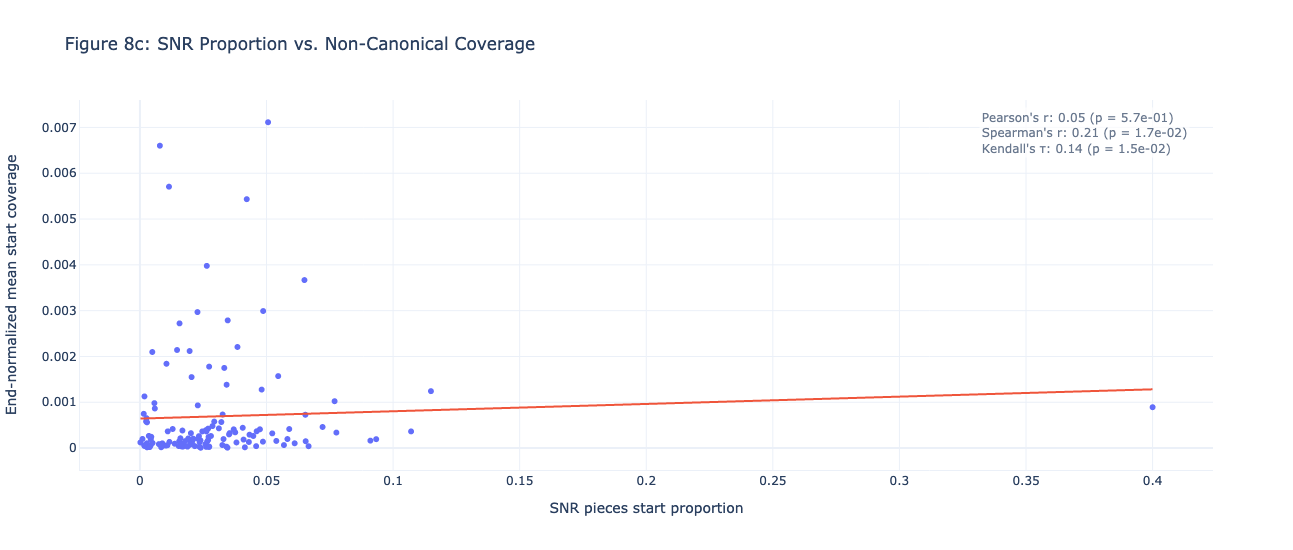

In [33]:
x_c = np.array([stats[6]/stats[3] for stats in statsByGene.values() if stats[2] != 0 and stats[6] != 0 and stats[0] != stats[2]])
y_c = np.array([stats[2]/stats[3]/(stats[0] - stats[2]) for stats in statsByGene.values() if stats[2] != 0 and stats[6] != 0 and stats[0] != stats[2]])
m_c, b_c = np.polyfit(x_c, y_c, 1)

corrs = (sps.pearsonr(x_c, y_c), sps.spearmanr(x_c, y_c), sps.kendalltau(x_c, y_c))

fig8c = go.Figure(data = [go.Scatter(x = x_c, y = y_c, mode = 'markers'),
                          go.Scatter(x = x_c, y = m_c * x_c + b_c, mode = 'lines')],
                  layout = {'title': 'Figure 8c: SNR Proportion vs. Non-Canonical Coverage',
                            'xaxis_title': 'SNR pieces start proportion', 'yaxis_title': 'End-normalized mean start coverage',
                            'height': 550, 'width': 550, 'showlegend': False,
                            'annotations': [go.Annotation(
                                text = "Pearson's r: {:.2f} (p = {:.1e})<br>Spearman's r: {:.2f} (p = {:.1e})<br>Kendall's &#964;: {:.2f} (p = {:.1e})".format(
                                    *[i for c in corrs for i in c]),
                                showarrow = False, align = 'left', bgcolor = 'white', opacity = 0.7,
                                xref = 'paper', xanchor = 'right', x = 0.98, yref = 'paper', yanchor = 'top', y = 0.98)]})
fig8c.show()

In [34]:
det.howLongSince(t_all)

0h:12m:45s elapsed
